 1. Importing required python modules:

In [42]:
# Standard Python:
import os
import re
import warnings
from datetime import datetime

# Data Wrangling:
import numpy as np
import pandas as pd

# Data Visualization:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Operations:
from scipy import stats

# Fuzzy String/Text Matching:
from fuzzywuzzy import process

2. Setting Notebook Configuration:

In [43]:
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

3. User-defined functions:

In [44]:
# User-defined function to clean names:
def clean_names(x):
    x = str(x)
    x = x.upper()
    x = re.sub(r"[^A-Z\s+]", "", x).strip()
    return x

In [45]:
# User-defined function to clean the sessionwise PPBS reading:
def clean_session_info(x):
    x = str(x)
    x = re.sub("(\d+\/\d+,?.)|(\d+\\\\\d+,)|(\d+,)", "", x).strip() # 12077,
    if x == "" or x == "Attender":
        return np.nan
    x = np.float64(x)
    return x

4. Data Cleaning:

4.1 Learning Session Information:

In [46]:
# Required sheets from the learning session information sheet:
required_sheets = [
    "MONDAY 1",
    "MONDAY 2",
    "TUESDAY 1",
    "TUESDAY 2",
    "FRIDAY 1",
    "FRIDAY 2",
]

# Defining the names of the columns for the table from each sheet:
column_names = [
    "NAME",
    "FBS_START",
    "PPBS_START",
    "HBA1C_START",
    "BP",
    "SESSION_1",
    "SESSION_2",
    "SESSION_3",
    "SESSION_4",
    "SESSION_5",
    "SESSION_6",
    "SESSION_7",
    "SESSION_8",
    "SESSION_9",
    "SESSION_10",
    "SESSION_11",
    "SESSION_12",
    "FBS_END",
    "PPBS_END",
    "HBA1C_END",
]

# Empty DataFrame to capture the consolidated output:
learning_session_info = []

# Reading each sheet and performing the data preparation process:
for sheet_name in required_sheets:
    temp_df = pd.read_excel(
        "Prerna 2022.xlsx", sheet_name=sheet_name, usecols=range(20), names=column_names
    ).assign(SHEET_NAME=sheet_name)

    # Removing extra information from the Name column:
    temp_df["NAME"] = temp_df["NAME"].apply(lambda x: clean_names(x))
    learning_session_info.append(temp_df)

# Consolidating
learning_session_info = (
    pd.concat(learning_session_info, axis=0)
    .reset_index(drop=True)
    .replace("-", np.nan)
    .replace("??", np.nan)
)

# Fixing the manual labeling issue in data:
learning_session_info.loc[
    learning_session_info["HBA1C_START"] == "9.6/7.9", "HBA1C_START"
] = 7.9

# Converting columns to their required data-types:
main_metrics = [
    "FBS_START",
    "PPBS_START",
    "HBA1C_START",
    "FBS_END",
    "PPBS_END",
    "HBA1C_END",
]

learning_session_info.loc[:, main_metrics] = learning_session_info.loc[
    :, main_metrics
].astype(float)

learning_session_info = (
    learning_session_info.dropna(subset=main_metrics)
    .reset_index(drop=True)
    .drop(columns=["BP"])
)

# Cleaning the session wise PPBS readings:
for i in range(1, 13):
    learning_session_info[f"SESSION_{i}"] = learning_session_info[f"SESSION_{i}"].apply(
        lambda x: clean_session_info(x)
    )

learning_session_info = learning_session_info[learning_session_info["NAME"] != "NAGAMANI"]
learning_session_info = learning_session_info[learning_session_info["NAME"] != "YASHODA S"]
learning_session_info = learning_session_info[learning_session_info["NAME"] != "VELLIYAMM"]
learning_session_info = learning_session_info[learning_session_info["NAME"] != "GANGADHAR NAIK"]
learning_session_info = learning_session_info[learning_session_info["NAME"] != "RAJASEKAR"]
learning_session_info = learning_session_info[learning_session_info["NAME"] != "YOSHADA S"]

# Creating a unique subject id to identify:
learning_session_info = learning_session_info.reset_index().rename(
    columns={"index": "PATIENT_ID"}
)
learning_session_info["PATIENT_ID"] += 1

# Computing the no. of sessions attended by each subject:
learning_session_info["COUNT_SESSION_MISSED"] = learning_session_info[
    [f"SESSION_{i}" for i in range(1, 13)]
].apply(lambda x: x.isnull().sum(), axis=1)

# Creating a column session day and id:
learning_session_info["SESSION_DAY"] = learning_session_info["SHEET_NAME"].str.replace(
    "\d+", ""
)
learning_session_info["SESSION_ID"] = learning_session_info["SHEET_NAME"].str.replace(
    "[A-Z]+", ""
)

# Extracting Subject information:
subject_information = learning_session_info.loc[
    :,
    [
        "PATIENT_ID",
        "NAME",
        "SESSION_DAY",
        "SESSION_ID",
        "FBS_START",
        "PPBS_START",
        "HBA1C_START",
        "FBS_END",
        "PPBS_END",
        "HBA1C_END",
        "COUNT_SESSION_MISSED",
    ],
]

# Generating count of sessions attended:
subject_information["COUNT_SESSION_ATTENDED"] = (
    12 - subject_information["COUNT_SESSION_MISSED"]
)

# Cleaning the session level information:
learning_session_info = learning_session_info.melt(
    id_vars=["PATIENT_ID", "NAME"],
    value_vars=[f"SESSION_{i}" for i in range(1, 13)],
    value_name="SESSION_PPBS",
    var_name="SESSION_COUNTER"
)

# Creating the session counter variable:
learning_session_info["SESSION_COUNTER"] = (
    learning_session_info["SESSION_COUNTER"]
    .str.replace("[A-Z_]+", "")
    .astype(int)
)

subject_information["HBA1C_END"][subject_information["HBA1C_END"]==704] = 7.04

# Clearing the memory:
del (
    required_sheets, column_names, main_metrics, i, sheet_name, temp_df
)

/tmp/ipykernel_962/1151512322.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_information["HBA1C_END"][subject_information["HBA1C_END"]==704] = 7.04


4.1.1 Viewing the first 3 rows of the subject_information table:

In [47]:
print(subject_information.shape)
subject_information.head(3)

(65, 12)


,PATIENT_ID,NAME,SESSION_DAY,SESSION_ID,FBS_START,PPBS_START,HBA1C_START,FBS_END,PPBS_END,HBA1C_END,COUNT_SESSION_MISSED,COUNT_SESSION_ATTENDED
0,1,JABEEN TAJ,MONDAY,1,214.0,357.0,12.5,128.0,326.0,9.3,3,9
1,2,CHANDRASHEKAR G,MONDAY,1,147.0,281.0,8.5,190.0,277.0,9.9,1,11
2,3,SHANTHI V F,MONDAY,1,140.0,286.0,12.6,113.0,141.0,10.0,2,10


4.1.2 Viewing the first 3 rows of the learning_session_info table:

In [48]:
learning_session_info.head(3)

,PATIENT_ID,NAME,SESSION_COUNTER,SESSION_PPBS
0,1,JABEEN TAJ,1,NaN
1,2,CHANDRASHEKAR G,1,163.0
2,3,SHANTHI V F,1,179.0


4.2 KAP Survey at the start of the study:

In [49]:
kap_survey_start = pd.read_excel("DRAFT ANALYSIS Anahat Prerna Questionnaire (Responses)_START.xlsx")
# "Anahat-Prerna_START (Responses).xlsx"

# Cleaning text from the Names column:
kap_survey_start["Name"] = kap_survey_start["Name"].apply(lambda x: clean_names(x))

# The names of the KAP survey table do not match that of the learning session,
# implementing fuzzy string matching:
fuzzy_matches = {}
for subject_name in subject_information["NAME"].to_list():
    search_result = process.extract(
        subject_name, kap_survey_start["Name"].to_list(), limit=1
    )
    fuzzy_matches[subject_name] = search_result[0][0]
print("Found ", len(fuzzy_matches.keys()), " fuzzy matches.")

fuzzy_matches = pd.Series(fuzzy_matches).reset_index()
fuzzy_matches.columns = ["SUBJECT_NAME", "MATCHED_NAME"]
fuzzy_matches["EXACT_MATCH"] = (
    fuzzy_matches["SUBJECT_NAME"] == fuzzy_matches["MATCHED_NAME"]
)
print(
    "Found ",
    fuzzy_matches[fuzzy_matches["EXACT_MATCH"] == True].shape[0],
    "exact matches.",
)
print(
    "Found ",
    fuzzy_matches[fuzzy_matches["EXACT_MATCH"] == False].shape[0],
    "fuzzy matches.",
)
fuzzy_matches[fuzzy_matches["EXACT_MATCH"]==True].sort_values(by="SUBJECT_NAME")

Found  65  fuzzy matches.
Found  31 exact matches.
Found  34 fuzzy matches.


,SUBJECT_NAME,MATCHED_NAME,EXACT_MATCH
54,ANAMARY,ANAMARY,True
21,ANBARASU,ANBARASU,True
46,ANIYAMMA,ANIYAMMA,True
30,ASHRAF UNNISA,ASHRAF UNNISA,True
17,ATHIKULLA,ATHIKULLA,True
12,BHAGYA,BHAGYA,True
20,GAYATHRI,GAYATHRI,True
45,ISMAIL KHAN,ISMAIL KHAN,True
0,JABEEN TAJ,JABEEN TAJ,True
27,JAHANGIR HUSSAIN,JAHANGIR HUSSAIN,True


In [50]:
fixed_names = [
    "CHANDRASHEKARG", "ANITHA", "JYOTHI LAKSHMI", "MANOHR", "USHA NAGAPAL",
    "MALAS", "REHANA", "VARALAKSHMI", "RAJA SHEKAR", "PUSHPA", "BASWARAJ",
    "INDRAMMA", "DINEAHEKARG", "CHIKKA SWAMY", "ESHWAR NAIK MK", "XAVIER",
    "REHMAN KHAN", "MRAJKUMAR", "RAJATHIR", "RAHAMAT UNNISA", "SUSHMA",
    "PARVATHI M", "SHANTHI", "SHANTHI G", "RANIS", "RANI", "KAVITHA M D",
    "ANIYAMMA","ANANTHA MURTHY", "ANEESA BEGUM", "RAJAMMA", "MAHALAXMIK",
    "MAHALAKSHMI", "JAYANTHI", "YOSSHODHA", "VELU"
]

In [51]:
# Manually checking the fuzzy-name matches:
fuzzy_matches[
    (fuzzy_matches["EXACT_MATCH"]==False) 
    & (~fuzzy_matches["MATCHED_NAME"].isin(fixed_names))
].sort_values(by=["SUBJECT_NAME"])

,SUBJECT_NAME,MATCHED_NAME,EXACT_MATCH


In [52]:
kap_survey_start.loc[
    kap_survey_start["Name"] == "CHANDRASHEKARG", "Name"
] = "CHANDRASHEKAR G"
kap_survey_start.loc[kap_survey_start["Name"] == "ANITHA", "Name"] = "ANITA"
subject_information.loc[
    subject_information["NAME"] == "JYOTHILAKSHMI", "NAME"
] = "JYOTHI LAKSHMI"
kap_survey_start.loc[kap_survey_start["Name"] == "MANOHR", "Name"] = "MANOHAR"
kap_survey_start.loc[kap_survey_start["Name"] == "USHA NAGAPAL", "Name"] = "USHA NAGPAL"
kap_survey_start.loc[kap_survey_start["Name"] == "MALAS", "Name"] = "MALA S"
subject_information.loc[subject_information["NAME"] == "RIHANA I", "NAME"] = "REHANA"
kap_survey_start.loc[
    kap_survey_start["Name"] == "VARALAKSHMI", "Name"
] = "VARALAKSHMI G"
kap_survey_start.loc[kap_survey_start["Name"] == "RAJA SHEKAR", "Name"] = "RAJASEKAR"
kap_survey_start.loc[kap_survey_start["Name"] == "PUSHPA", "Name"] = "PUSHPA R"
kap_survey_start.loc[kap_survey_start["Name"] == "BASWARAJ", "Name"] = "BASVARAJ"
kap_survey_start.loc[kap_survey_start["Name"] == "INDRAMMA", "Name"] = "INDIRAMMA"
kap_survey_start.loc[kap_survey_start["Name"] == "DINEAHEKARG", "Name"] = "DINASHEKAR"
kap_survey_start.loc[kap_survey_start["Name"] == "CHIKKA SWAMY", "Name"] = "CHIKKASWAMY"
kap_survey_start.loc[
    kap_survey_start["Name"] == "ESHWAR NAIK MK", "Name"
] = "ESHWAR NAIK"
kap_survey_start.loc[kap_survey_start["Name"] == "XAVIER", "Name"] = "XAVIER C"
kap_survey_start.loc[kap_survey_start["Name"] == "REHMAN KHAN", "Name"] = "RAHAMAN KHAN"
kap_survey_start.loc[kap_survey_start["Name"] == "MRAJKUMAR", "Name"] = "RAJKUMAR"
kap_survey_start.loc[kap_survey_start["Name"] == "RAJATHIR", "Name"] = "RAJATHI"
kap_survey_start.loc[
    kap_survey_start["Name"] == "RAHAMAT UNNISA", "Name"
] = "RAHAMATH UNNISA"
kap_survey_start.loc[kap_survey_start["Name"] == "SUSHMA", "Name"] = "SUSAMA"
kap_survey_start.loc[kap_survey_start["Name"] == "PARVATHI M", "Name"] = "PARVATHI"
kap_survey_start.loc[kap_survey_start["Name"] == "SHANTHI", "Name"] = "SHANTHI V F"
kap_survey_start.loc[kap_survey_start["Name"] == "SHANTHI G", "Name"] = "SHANTI G F"
kap_survey_start.loc[kap_survey_start["Name"] == "RANIS", "Name"] = "RANI S"
kap_survey_start.loc[kap_survey_start["Name"] == "RANI", "Name"] = "RANI F"
kap_survey_start.loc[kap_survey_start["Name"] == "KAVITHA M D", "Name"] = "KAVITHA D"
kap_survey_start.loc[kap_survey_start["Name"] == "ANIYAMMA", "Name"] = "KANIYAMMA"
kap_survey_start.loc[
    kap_survey_start["Name"] == "ANANTHA MURTHY", "Name"
] = "ANATHAMURTHY"
kap_survey_start.loc[kap_survey_start["Name"] == "ANEESA BEGUM", "Name"] = "ANEESA"
kap_survey_start.loc[kap_survey_start["Name"] == "RAJAMMA", "Name"] = "RAJAMMA T P"
kap_survey_start.loc[kap_survey_start["Name"] == "JAYANTHI", "Name"] = "JAYANTHI B"
kap_survey_start.loc[kap_survey_start["Name"] == "MAHALAXMIK", "Name"] = "MAHALAXMI B L"
kap_survey_start.loc[kap_survey_start["Name"] == "MAHALAKSHMI", "Name"] = "MAHALAXMI J"
kap_survey_start.loc[kap_survey_start["Name"] == "YOSSHODHA", "Name"] = "YOSHADA S"
# kap_survey_start.loc[kap_survey_start["Name"] == "VELU", "Name"] = "VELLIYAMM"

# Filtering the KAP survey data only for the subjects who took part in the study:
kap_survey_start = kap_survey_start.loc[
    kap_survey_start["Name"].isin(subject_information["NAME"].to_list()), :
]

In [53]:
print(kap_survey_start.shape)
kap_survey_start.head(3)

(64, 75)


,Timestamp,Name,Match,Age,Gender,Marital Status,House ownership,Family members,glucose is too high,Score,How many types of Diabetes are there?,Score.1,What are the major causes of T2DM?,Score.2,Is Type 2 diabetes hereditary?,Score.3,Which diet is restricted in T2DM?,Score.4,A diet high in fat and sugar,Score.5,Can type 2 diabetes be cured?,Score.6,Which one of the following is symptoms of T2DM?,Score.7,Insulin is a hormone which,Score.8,The diagnosis of Type 2 diabetes in made by,Score.9,How to control and manage Type 2 diabetes?,Score.10,Being overweight/obese,Score.11,To achieve and maintain a healthy weight,Score.12,Smoking,Score.13,T2DM may cause health problems (complications) such as,Score.14,KNOWLEDGE TOTAL SCORE,Diabetes is the worst thing that can ever happened to me,I would feel embarrassed about having diabetes.,Most people would find it difficult to adjust to having diabetes.,Seeking help from the clinic for T4DM should be a priority.,I think some1 with diabetes should follow a controlled diet.,I think it is good to include green leafy vegetables and fruits in my daily diet.,I think it is good to avoid extra added salts and sugar in my diet.,It is good to have fruits rather than sweets.,It is important for a diabetic to maintain a healthy weight.,Diabetes complications may be prevented if blood glucose level is well control.,Checking of your blood sugar level is important.,Family members should be screened for diabetes.,Missing medicines for a diabetic person has a negative effect on the disease control,Regular visits to the clinic or nurses at the clinic enable 1 to control the disease.,TOTAL SCORE ATTITUDE,Do you go every six months to check your blood glucose,Score.15,Do you control your weight?,Score.16,Do you normally do physical exercise to maintain your weight?,Score.17,How much time do you spend for exercise per day?,Score.18,Do you smoke?,Score.19,Do you currently drink alcohol?,Score.20,Do you take food timely?,Score.21,Do you add extra salt to your regular diet?,Score.22,Do you eat fruits?,Score.23,Do you eat vegetables?,Score.24,PRACTICES TOTAL SCORE
0,2022-09-20 09:46:20.921,RANI F,NaN,51-60,Female,Married,Rented,5-8,I don't know,0,I don't know,0,Physical inactivity and Unhealthy foods,1,I don't know,0,Potato/rice,1,I don’t know,0,I don’t know,0,Weight loss,1,I don’t know,0,I don’t know,0,Regular exercise,1,I don’t know,0,Exercise regularly,1,I don’t know,0,Kidney disease,1,6,5,4,5,4,4,5,5,4,5,3,5,5,5,4,63,No,0,Yes,1,Yes,1,Yes,1,No,1,No,1,No,0,Yes,0,Yes,1,Yes,1,7
2,2022-09-20 14:52:36.964,JABEEN TAJ,NaN,41-50,Female,Married,Rented,<4,Yes,1,I don't know,0,Physical inactivity and Unhealthy foods,1,Yes,1,Potato/rice,1,Increases blood sugar levels,1,Yes,0,Weight loss,1,I don’t know,0,A simple blood test measuring your blood gluco...,1,Regular exercise,1,Increases the risk of getting T2DM,1,Exercise regularly,1,I don’t know,0,I don’t know,0,10,5,5,4,4,4,5,5,4,5,5,5,5,5,5,66,Yes,1,Yes,1,No,0,No,0,No,1,No,1,No,0,No,1,Yes,1,Yes,1,7
3,2022-09-20 14:58:00.724,SHANTI G F,NaN,60-70,Female,Married,Rented,<4,I don't know,0,I don't know,0,I don't know,0,I don't know,0,Potato/rice,1,I don’t know,0,I don’t know,0,Weight loss,1,I don’t know,0,I don’t know,0,Regular exercise,1,I don’t know,0,Exercise regularly,1,I don’t know,0,I don’t know,0,4,5,4,5,4,5,4,5,4,5,3,5,4,5,4,62,Yes,1,Yes,1,Yes,1,Yes,1,No,1,No,1,Yes,1,Yes,0,Yes,1,Yes,1,9


4.3 KAP Survey at the end of the study:

In [54]:
kap_survey_end = pd.read_excel("DRAFT ANALYSIS AnaahatFoundation_END (Responses).xlsx")
#"AnaahatFoundation_END (Responses).xlsx"
kap_survey_end = kap_survey_end.rename(columns={"Patient Name": "Name"})

# Cleaning text from the Names column:
kap_survey_end["Name"] = kap_survey_end["Name"].apply(lambda x: clean_names(x))

# The names of the KAP survey table do not match that of the learning session,
# implementing fuzzy string matching:
fuzzy_matches = {}
for subject_name in subject_information["NAME"].to_list():
    search_result = process.extract(
        subject_name, kap_survey_end["Name"].to_list(), limit=1
    )
    fuzzy_matches[subject_name] = search_result[0][0]
print("Found ", len(fuzzy_matches.keys()), " fuzzy matches.")

fuzzy_matches = pd.Series(fuzzy_matches).reset_index()
fuzzy_matches.columns = ["SUBJECT_NAME", "MATCHED_NAME"]
fuzzy_matches["EXACT_MATCH"] = (
    fuzzy_matches["SUBJECT_NAME"] == fuzzy_matches["MATCHED_NAME"]
)
print(
    "Found ",
    fuzzy_matches[fuzzy_matches["EXACT_MATCH"] == True].shape[0],
    "exact matches.",
)
print(
    "Found ",
    fuzzy_matches[fuzzy_matches["EXACT_MATCH"] == False].shape[0],
    "fuzzy matches.",
)
fuzzy_matches[fuzzy_matches["EXACT_MATCH"]==True].sort_values(by="SUBJECT_NAME")

Found  65  fuzzy matches.
Found  29 exact matches.
Found  36 fuzzy matches.


,SUBJECT_NAME,MATCHED_NAME,EXACT_MATCH
54,ANAMARY,ANAMARY,True
14,ANEESA,ANEESA,True
30,ASHRAF UNNISA,ASHRAF UNNISA,True
17,ATHIKULLA,ATHIKULLA,True
12,BHAGYA,BHAGYA,True
23,CHIKKASWAMY,CHIKKASWAMY,True
45,ISMAIL KHAN,ISMAIL KHAN,True
0,JABEEN TAJ,JABEEN TAJ,True
61,JAYAMMA C,JAYAMMA C,True
41,JAYANTHI B,JAYANTHI B,True


In [55]:
fixed_names = [
    "ANANTHA MURTHY B", "ANBARARU S", "ANITHA", "BASAVARAJ", "DINASHAKER",
    "ESHWARAN NAIK MK", "SHANTHI V", "RIHANA", "INDRAMMA", "JAHANGIR", "PREMA",
    "R MANOHAR", "RAJAMMA", "RAJATHI R", "KANNIAMMAL", "GAYATHRI K", 
    "RAHAMATHUNNISA", "RAMAAS", "PAPAMMA M", "SHANTHAMMA M", "SYEDA TABASUM",
    "NIRMALA A", "SUSHILA", "SUSAMA BARICK", "RANI", "A RAVI", "SHANTHI G",
    "MANJULA A S", "PARVATHI M", "JYOTHILAKSHMI", "MAHALAXMI J"
]

In [56]:
# Manually checking the fuzzy-name matches:
fuzzy_matches[
    (fuzzy_matches["EXACT_MATCH"]==False) 
    & (~fuzzy_matches["MATCHED_NAME"].isin(fixed_names))
].sort_values(by=["SUBJECT_NAME"]).reset_index(drop=True)

,SUBJECT_NAME,MATCHED_NAME,EXACT_MATCH


In [57]:
kap_survey_end.loc[kap_survey_end["Name"] == "ANANTHA MURTHY B", "Name"] = "ANATHAMURTHY"
kap_survey_end.loc[kap_survey_end["Name"] == "ANBARARU S", "Name"] = "ANBARASU"
kap_survey_end.loc[kap_survey_end["Name"] == "ANITHA", "Name"] = "ANITA"
kap_survey_end.loc[kap_survey_end["Name"] == "BASAVARAJ", "Name"] = "BASVARAJ"
kap_survey_end.loc[kap_survey_end["Name"] == "DINASHAKER", "Name"] = "DINASHEKAR"
kap_survey_end.loc[kap_survey_end["Name"] == "ESHWARAN NAIK MK", "Name"] = "ESHWAR NAIK"
kap_survey_end.loc[kap_survey_end["Name"] == "SHANTHI V", "Name"] = "SHANTHI V F"
kap_survey_end.loc[kap_survey_end["Name"] == "RIHANA", "Name"] = "REHANA"
kap_survey_end.loc[kap_survey_end["Name"] == "INDRAMMA", "Name"] = "INDIRAMMA"
kap_survey_end.loc[kap_survey_end["Name"] == "JAHANGIR", "Name"] = "JAHANGIR HUSSAIN"
kap_survey_end.loc[kap_survey_end["Name"] == "PREMA", "Name"] = "PREEMA"
kap_survey_end.loc[kap_survey_end["Name"] == "R MANOHAR", "Name"] = "MANOHAR"
kap_survey_end.loc[kap_survey_end["Name"] == "RAJAMMA", "Name"] = "RAJAMMA T P"
kap_survey_end.loc[kap_survey_end["Name"] == "RAJATHI R", "Name"] = "RAJATHI"
kap_survey_end.loc[kap_survey_end["Name"] == "KANNIAMMAL", "Name"] = "KANIYAMMA"
kap_survey_end.loc[kap_survey_end["Name"] == "GAYATHRI K", "Name"] = "GAYATHRI"
kap_survey_end.loc[kap_survey_end["Name"] == "RAHAMATHUNNISA", "Name"] = "RAHAMATH UNNISA"
kap_survey_end.loc[kap_survey_end["Name"] == "RAMAAS", "Name"] = "RAMAA"
kap_survey_end.loc[kap_survey_end["Name"] == "PAPAMMA M", "Name"] = "PAPPAMMA"
kap_survey_end.loc[kap_survey_end["Name"] == "SHANTHAMMA M", "Name"] = "SHANTHAMMA"
kap_survey_end.loc[kap_survey_end["Name"] == "SYEDA TABASUM", "Name"] = "SYEDA TABASSNUM"
kap_survey_end.loc[kap_survey_end["Name"] == "NIRMALA A", "Name"] = "NIRMALA"
kap_survey_end.loc[kap_survey_end["Name"] == "SUSHILA", "Name"] = "SUSHILA S"
kap_survey_end.loc[kap_survey_end["Name"] == "SUSAMA BARICK", "Name"] = "SUSAMA"
kap_survey_end.loc[kap_survey_end["Name"] == "RANI", "Name"] = "RANI F"
kap_survey_end.loc[kap_survey_end["Name"] == "A RAVI", "Name"] = "RAVI"
kap_survey_end.loc[kap_survey_end["Name"] == "SHANTHI G", "Name"] = "SHANTI G F"
kap_survey_end.loc[kap_survey_end["Name"] == "MANJULA A S", "Name"] = "MANJULA"
kap_survey_end.loc[kap_survey_end["Name"] == "PARVATHI M", "Name"] = "PARVATHI"
kap_survey_end.loc[kap_survey_end["Name"] == "JYOTHILAKSHMI", "Name"] = "JYOTHI LAKSHMI"
kap_survey_end.loc[kap_survey_end["Name"] == "MAHALAKSHMI BL", "Name"] = "MAHALAXMI B L"
# Filtering the KAP survey data only for the subjects who took part in the study:
kap_survey_end = kap_survey_end.loc[
    kap_survey_end["Name"].isin(subject_information["NAME"].to_list()), :
]

In [58]:
print(kap_survey_end.shape)
kap_survey_end.head(3)

(60, 98)


,Timestamp,Name,Is patient still part of the program?,Diagnosis,Age,Sex,Marital Status,House Ownership,Family Members,Occupation Status,Education Level,Family Member with T2DM,T2DM is a chronic disease in which blood glucose is too high,Score,How many types of Diabetes are there?,Score.1,What are the major causes of T2DM?,Score.2,Is Type 2 diabetes hereditary?,Score.3,Which diet is restricted in T2DM?,Score.4,A diet high in fat and sugar,Score.5,Can type 2 diabetes be cured?,Score.6,Which one of the following is symptoms of T2DM?,Score.7,Insulin is a hormone which,Score.8,The diagnosis of Type 2 diabetes in made by,Score.9,How to control and manage Type 2 diabetes?,Score.10,Being overweight/obese,Score.11,To achieve and maintain a healthy weight,Score.12,Smoking,Score.13,T2DM may cause health problems (complications) such as,Score.14,KNOWLEDGE TOTAL SCORE,Likert scale scoring system consisting only of responses [Diabetes is the worst thing that can ever happened to me],Score.15,Likert scale scoring system consisting only of responses [I would feel embarrassed about having diabetes],Score.16,Likert scale scoring system consisting only of responses [Most people would find it difficult to adjust to having diabetes],Score.17,Likert scale scoring system consisting only of responses [Seeking help from the clinic for T2DM should be a priority],Score.18,Likert scale scoring system consisting only of responses [I think someone with diabetes should follow a controlled diet],Score.19,Likert scale scoring system consisting only of responses [I think it is good to include green leafy vegetables and fruits in my daily diet],Score.20,Likert scale scoring system consisting only of responses [I think it is good to avoid extra added salts and sugar in my diet],Score.21,Likert scale scoring system consisting only of responses [It is good to have fruits rather than sweets],Score.22,Likert scale scoring system consisting only of responses [It is important for a diabetic to maintain a healthy weight],Score.23,Likert scale scoring system consisting only of responses [Diabetes complications may be prevented if blood glucose level is well control],Score.24,Likert scale scoring system consisting only of responses [Checking of your blood sugar level is important],Score.25,Likert scale scoring system consisting only of responses [Family members should be screened for diabetes],Score.26,Likert scale scoring system consisting only of responses [Missing medicines for a diabetic person has a negative effect on the disease control],Score.27,Likert scale scoring system consisting only of responses [Regular visits to the clinic or nurses at the clinic enable one to control the disease],Score.28,TOTAL SCORE ATTITUDE,Do you go every six months to check your blood glucose?,Score.29,Do you control your weight?,Score.30,Do you normally do physical exercise to maintain your weight?,Score.31,How much time do you spend for exercise per day?,Score.32,Do you smoke?,Score.33,Do you currently drink alcohol?,Score.34,Do you take food timely?,Score.35,Do you add extra salt to your regular diet?,Score.36,Do you eat fruits?,Score.37,Do you eat vegetables?,Score.38,TOTAL SCORE PRACTICES,How was your experience of attending the lifestyle modification sessions? Did it help you in managing your condition? Were there any challenges that you faced while attending these sessions?,"What do you think about the number of sessions planned? Do you think the number of sessions were too many, too less or it was appropriate?","After joining this program and attending the sessions, has there been any changes that you have done to your lifestyle or habits? Or has there been any recent changes in your health (good or bad) that you would like to share?","After joining this program and attending the sessions, has there been any changes that you have done to your lifestyle or habits? Or has there been any recent changes in your health (good or bad) that you would like to share?.1",What are some of

In [59]:
subject_information

,PATIENT_ID,NAME,SESSION_DAY,SESSION_ID,FBS_START,PPBS_START,HBA1C_START,FBS_END,PPBS_END,HBA1C_END,COUNT_SESSION_MISSED,COUNT_SESSION_ATTENDED
0,1,JABEEN TAJ,MONDAY,1,214.0,357.0,12.5,128.0,326.0,9.30,3,9
1,2,CHANDRASHEKAR G,MONDAY,1,147.0,281.0,8.5,190.0,277.0,9.90,1,11
2,3,SHANTHI V F,MONDAY,1,140.0,286.0,12.6,113.0,141.0,10.00,2,10
3,4,PREEMA,MONDAY,1,151.0,196.0,9.0,141.0,235.0,7.90,2,10
4,5,ANITA,MONDAY,1,160.0,202.0,9.6,112.0,146.0,7.60,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
60,64,LAKSHMI R,FRIDAY,2,119.0,308.0,10.5,116.0,192.0,6.60,0,12
61,65,JAYAMMA C,FRIDAY,2,139.0,309.0,9.6,87.0,219.0,7.00,5,7
62,66,BASVARAJ,FRIDAY,2,234.0,290.0,11.7,172.0,185.0,10.00,5,7
63,67,SAROJAMMA,FRIDAY,2,131.0,279.0,7.6,114.0,198.0,7.50,4,8


In [60]:
subject_information.groupby(["SESSION_DAY", "SESSION_ID"])['NAME'].count().reset_index()

,SESSION_DAY,SESSION_ID,NAME
0,FRIDAY,1,16
1,FRIDAY,2,10
2,MONDAY,1,6
3,MONDAY,2,5
4,TUESDAY,1,14
5,TUESDAY,2,14


[]

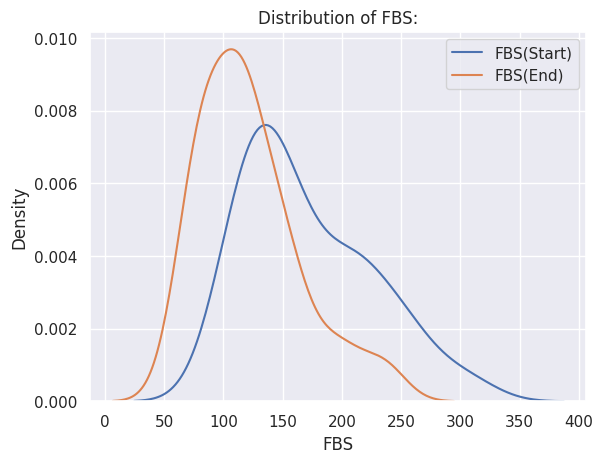

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.kdeplot(data=subject_information, x="FBS_START").set_title("Distribution of FBS:")
sns.kdeplot(data=subject_information, x="FBS_END").set_title("Distribution of FBS:")
plt.legend(labels=['FBS(Start)', 'FBS(End)'])
plt.xlabel("FBS")
plt.plot()

In [62]:
subject_information["HBA1C_START"].max()

15.0

[]

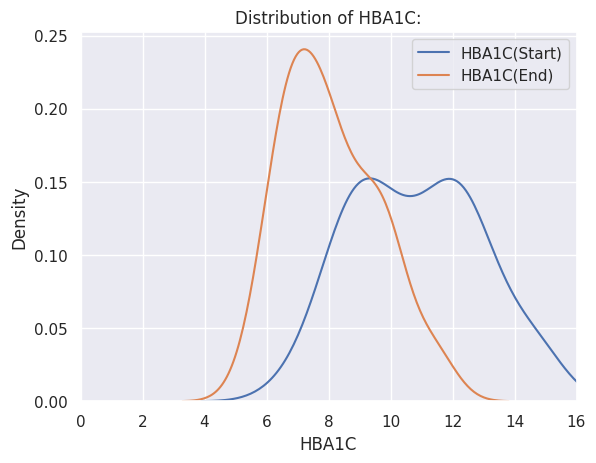

In [63]:
sns.kdeplot(data=subject_information, x="HBA1C_START").set(xlim=(0,16))
sns.kdeplot(data=subject_information, x="HBA1C_END").set(xlim=(0,16))
plt.legend(labels=['HBA1C(Start)', 'HBA1C(End)'])
plt.title("Distribution of HBA1C:")
plt.xlabel("HBA1C")
plt.plot()

[]

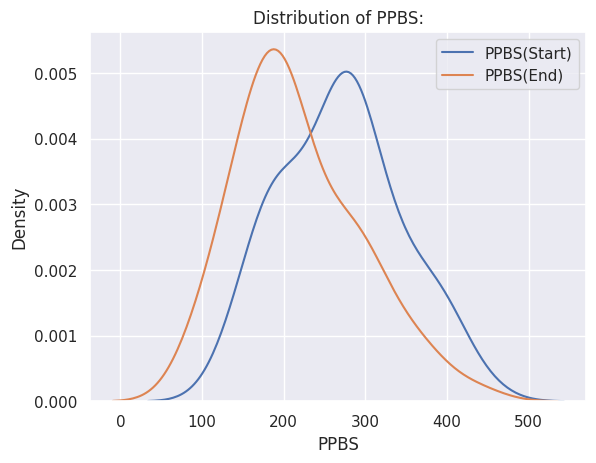

In [64]:
sns.kdeplot(data=subject_information, x="PPBS_START")
sns.kdeplot(data=subject_information, x="PPBS_END")
plt.legend(labels=['PPBS(Start)', 'PPBS(End)'])
plt.title("Distribution of PPBS:")
plt.xlabel("PPBS")
plt.plot()

[]

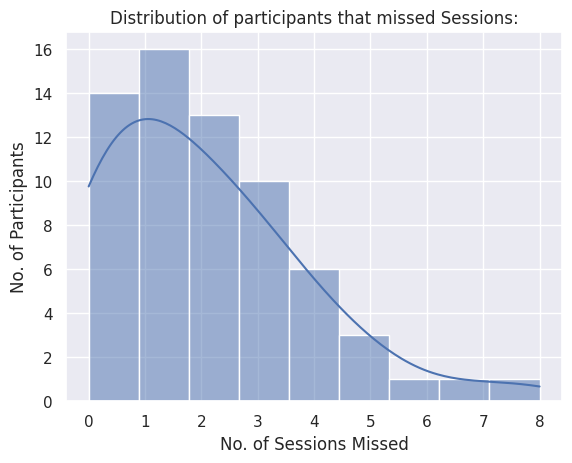

In [65]:
sns.histplot(data=subject_information, x="COUNT_SESSION_MISSED", kde=True)
plt.title("Distribution of participants that missed Sessions:")
plt.xlabel("No. of Sessions Missed")
plt.ylabel("No. of Participants")
plt.plot()

Text(0, 0.5, 'HBA1C at the end of the study')

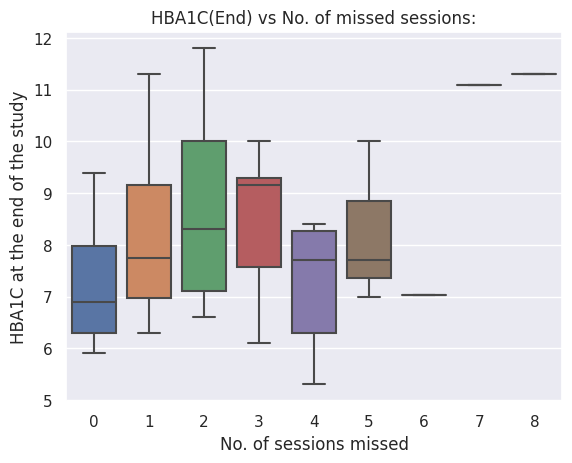

In [66]:
sns.boxplot(data=subject_information, x="COUNT_SESSION_MISSED", y="HBA1C_END")
plt.title("HBA1C(End) vs No. of missed sessions:")
plt.xlabel("No. of sessions missed")
plt.ylabel("HBA1C at the end of the study")

Text(0, 0.5, 'PPBS at the end of the study')

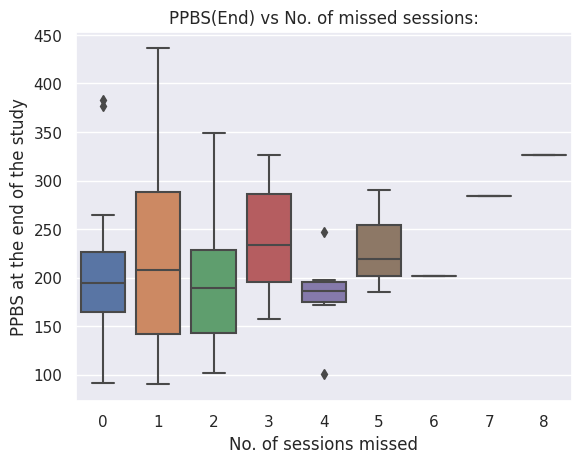

In [67]:
sns.boxplot(data=subject_information, x="COUNT_SESSION_MISSED", y="PPBS_END")
plt.title("PPBS(End) vs No. of missed sessions:")
plt.xlabel("No. of sessions missed")
plt.ylabel("PPBS at the end of the study")

Text(0, 0.5, 'FBS at the end of the study')

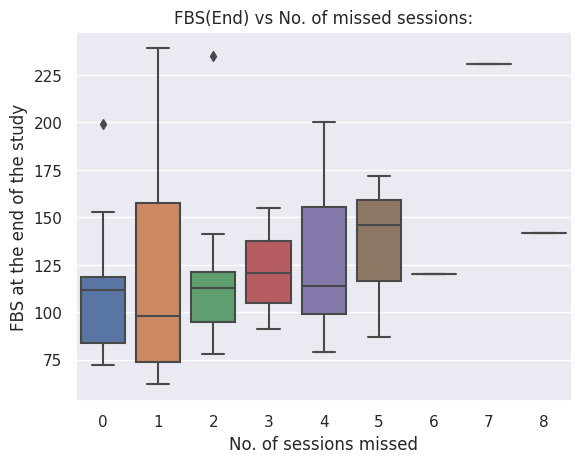

In [68]:
sns.boxplot(data=subject_information, x="COUNT_SESSION_MISSED", y="FBS_END")
plt.title("FBS(End) vs No. of missed sessions:")
plt.xlabel("No. of sessions missed")
plt.ylabel("FBS at the end of the study")

Text(0, 0.5, 'No. of sessions missed')

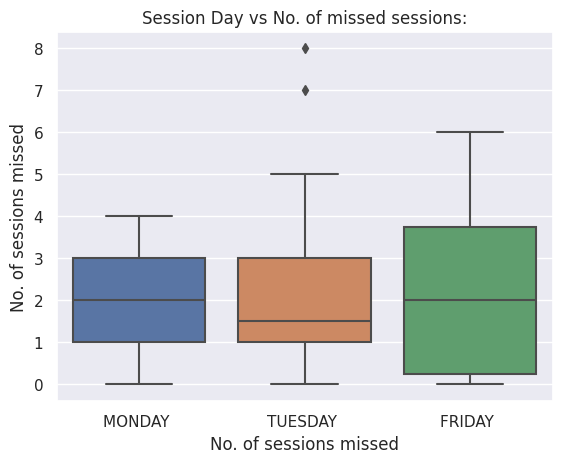

In [69]:
sns.boxplot(data=subject_information, x="SESSION_DAY", y="COUNT_SESSION_MISSED")
plt.title("Session Day vs No. of missed sessions:")
plt.xlabel("No. of sessions missed")
plt.ylabel("No. of sessions missed")

In [70]:
subject_information = subject_information.merge(
    right=kap_survey_end[['Name', 'Sex']],
    left_on = "NAME",
    right_on = "Name",
    how="inner"
)

Text(0, 0.5, 'No. of Participants')

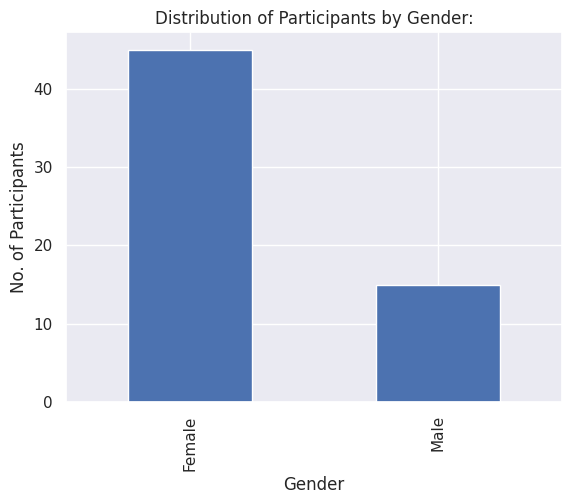

In [71]:
subject_information.groupby("Sex").size().plot(kind="bar")
plt.title("Distribution of Participants by Gender:")
plt.xlabel("Gender")
plt.ylabel("No. of Participants")

In [72]:
subject_information.groupby("Sex").size()

Sex
Female    45
Male      15
dtype: int64

Text(0, 0.5, 'No. of Participants')

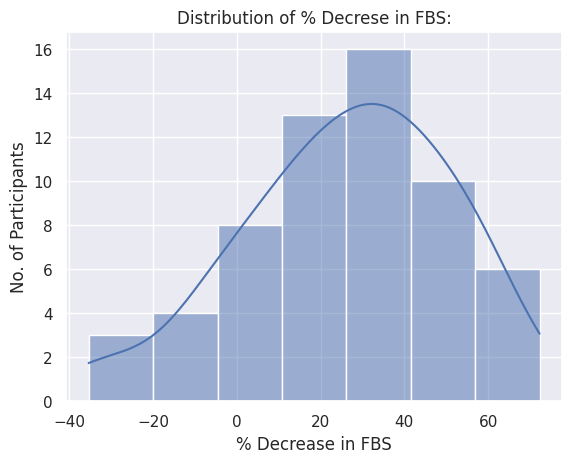

In [73]:
subject_information["PER_DEC_IN_FBS"] = ((subject_information["FBS_START"] - subject_information["FBS_END"])/subject_information["FBS_START"])*100
sns.histplot(data=subject_information, x="PER_DEC_IN_FBS", kde=True)
plt.title("Distribution of % Decrese in FBS:")
plt.xlabel("% Decrease in FBS")
plt.ylabel("No. of Participants")

Text(0, 0.5, 'No. of Participants')

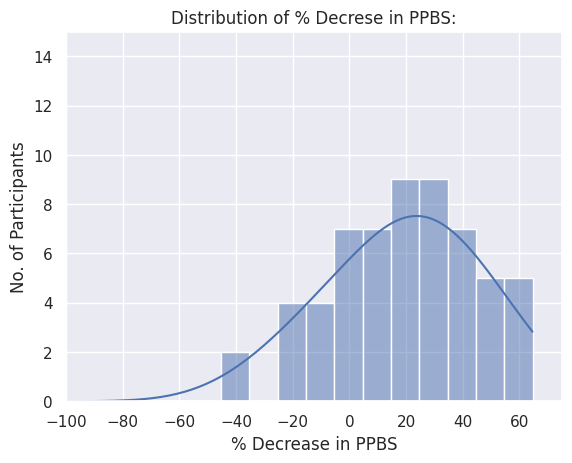

In [74]:
subject_information["PER_DEC_IN_PPBS"] = ((subject_information["PPBS_START"] - subject_information["PPBS_END"])/subject_information["PPBS_START"])*100
sns.histplot(data=subject_information, x="PER_DEC_IN_PPBS", kde=True, binwidth=10).set(xlim=(-100,75), ylim=(0,15))
plt.title("Distribution of % Decrese in PPBS:")
plt.xlabel("% Decrease in PPBS")
plt.ylabel("No. of Participants")

Text(0, 0.5, 'No. of Participants')

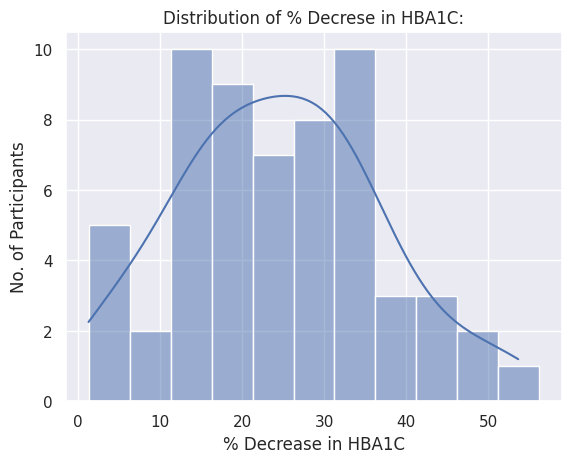

In [75]:
subject_information["PER_DEC_IN_HBA1C"] = ((subject_information["HBA1C_START"] - subject_information["HBA1C_END"])/subject_information["HBA1C_START"])*100
sns.histplot(data=subject_information, x="PER_DEC_IN_HBA1C", kde=True, binwidth=5)
plt.title("Distribution of % Decrese in HBA1C:")
plt.xlabel("% Decrease in HBA1C")
plt.ylabel("No. of Participants")

In [76]:
pd.concat([
    subject_information["FBS_START"].describe(),
    subject_information["FBS_END"].describe()
], axis=1).T

,count,mean,std,min,25%,50%,75%,max
FBS_START,60.0,171.116667,55.590845,96.0,129.75,154.5,214.0,316.0
FBS_END,60.0,120.150000,41.618455,62.0,88.50,115.0,141.0,239.0


In [77]:
pd.concat([
    subject_information["PPBS_START"].describe(),
    subject_information["PPBS_END"].describe()
], axis=1).T

,count,mean,std,min,25%,50%,75%,max
PPBS_START,60.0,267.216667,71.751240,134.0,202.75,271.0,309.25,446.0
PPBS_END,60.0,214.366667,73.182837,90.0,164.50,196.0,262.50,436.0


In [78]:
subject_information.groupby(["SESSION_DAY", "SESSION_ID"]).size()

SESSION_DAY  SESSION_ID
FRIDAY        1            14
              2            10
MONDAY        1             5
              2             5
TUESDAY       1            14
              2            12
dtype: int64

In [79]:
pd.concat([
    subject_information["HBA1C_START"].describe(),
    subject_information["HBA1C_END"].describe()
], axis=1).T

,count,mean,std,min,25%,50%,75%,max
HBA1C_START,60.0,10.735000,2.011983,6.6,9.15,10.85,12.325,15.0
HBA1C_END,60.0,7.975667,1.467594,5.3,6.90,7.75,9.000,11.8


Paired T-test for HBA1C:

In [80]:
hypothesis_test_results = []
metrics = ["FBS", "PPBS", "HBA1C"]

for metric in metrics:
    two_sided = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values
    )
    greater = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values,
        alternative="greater"
    )
    lesser = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values,
        alternative="less"
    )
    temp_results = pd.DataFrame({
        "Two-Sided": {
            "Test-Statistic": two_sided[0],
            "P-Value": two_sided[1]
        },
        "Greater": {
            "Test-Statistic": greater[0],
            "P-Value": greater[1]
        },
        "Lesser": {
            "Test-Statistic": lesser[0],
            "P-Value": lesser[1]
        }
    }).T.assign(METRIC=metric)

    hypothesis_test_results.append(temp_results)
hypothesis_test_results = pd.concat(hypothesis_test_results, axis=0)
hypothesis_test_results

,Test-Statistic,P-Value,METRIC
Two-Sided,7.080395,1.977512e-09,FBS
Greater,7.080395,9.887558e-10,FBS
Lesser,7.080395,1.000000e+00,FBS
Two-Sided,4.586498,2.398456e-05,PPBS
Greater,4.586498,1.199228e-05,PPBS
Lesser,4.586498,9.999880e-01,PPBS
Two-Sided,12.968184,6.383748e-19,HBA1C
Greater,12.968184,3.191874e-19,HBA1C
Lesser,12.968184,1.000000e+00,HBA1C


In [92]:
kap_survey_end.columns

Index(['Timestamp', 'Name', 'Is patient still part of the program?',
       'Diagnosis', 'Age', 'Sex', 'Marital Status', 'House Ownership',
       'Family Members', 'Occupation Status', 'Education Level',
       'Family Member with T2DM ',
       'T2DM is a chronic disease in which blood glucose is too high', 'Score',
       'How many types of Diabetes are there? ', 'Score.1',
       'What are the major causes of T2DM?', 'Score.2',
       'Is Type 2 diabetes hereditary? ', 'Score.3',
       'Which diet is restricted in T2DM? ', 'Score.4',
       'A diet high in fat and sugar ', 'Score.5',
       'Can type 2 diabetes be cured? ', 'Score.6',
       'Which one of the following is symptoms of T2DM? ', 'Score.7',
       'Insulin is a hormone which', 'Score.8',
       'The diagnosis of Type 2 diabetes in made by', 'Score.9',
       'How to control and manage Type 2 diabetes? ', 'Score.10',
       'Being overweight/obese ', 'Score.11',
       'To achieve and maintain a healthy weight ', 'Scor

In [95]:
subject_information.columns

Index(['PATIENT_ID', 'NAME', 'SESSION_DAY', 'SESSION_ID', 'FBS_START',
       'PPBS_START', 'HBA1C_START', 'FBS_END', 'PPBS_END', 'HBA1C_END',
       'COUNT_SESSION_MISSED', 'COUNT_SESSION_ATTENDED', 'Name', 'Sex',
       'PER_DEC_IN_FBS', 'PER_DEC_IN_PPBS', 'PER_DEC_IN_HBA1C'],
      dtype='object')

In [97]:
subject_information = subject_information.merge(
    right = kap_survey_end[["Name", "KNOWLEDGE TOTAL SCORE", "TOTAL SCORE ATTITUDE", "TOTAL SCORE PRACTICES"]].add_suffix("_END"),
    left_on = "NAME",
    right_on = "Name_END",
    how = "inner"
)

In [102]:
subject_information = subject_information.merge(
    right = (
        kap_survey_start[["Name", "KNOWLEDGE TOTAL SCORE", "TOTAL SCORE ATTITUDE", "PRACTICES TOTAL SCORE"]]
        .rename(columns = {"PRACTICES TOTAL SCORE": "TOTAL SCORE PRACTICES"}).add_suffix("_START")
    ),
    left_on = "NAME",
    right_on = "Name_START",
    how = "inner"
)

In [103]:
subject_information.columns

Index(['PATIENT_ID', 'NAME', 'SESSION_DAY', 'SESSION_ID', 'FBS_START',
       'PPBS_START', 'HBA1C_START', 'FBS_END', 'PPBS_END', 'HBA1C_END',
       'COUNT_SESSION_MISSED', 'COUNT_SESSION_ATTENDED', 'Name', 'Sex',
       'PER_DEC_IN_FBS', 'PER_DEC_IN_PPBS', 'PER_DEC_IN_HBA1C', 'Name_END',
       'KNOWLEDGE TOTAL SCORE_END', 'TOTAL SCORE ATTITUDE_END',
       'TOTAL SCORE PRACTICES_END', 'Name_START',
       'KNOWLEDGE TOTAL SCORE_START', 'TOTAL SCORE ATTITUDE_START',
       'TOTAL SCORE PRACTICES_START'],
      dtype='object')

[]

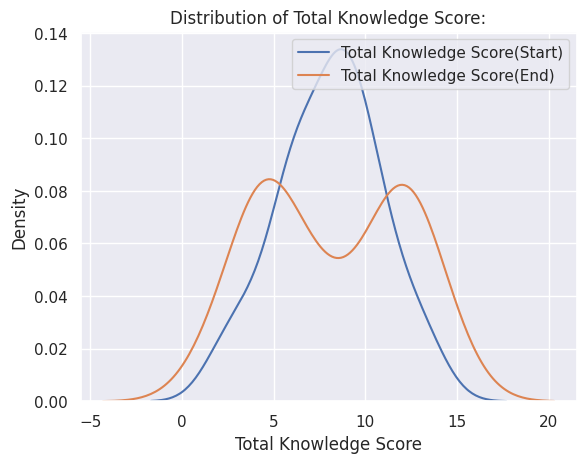

In [104]:
sns.kdeplot(data=subject_information, x="KNOWLEDGE TOTAL SCORE_START")
sns.kdeplot(data=subject_information, x="KNOWLEDGE TOTAL SCORE_END")
plt.legend(labels=['Total Knowledge Score(Start)', 'Total Knowledge Score(End)'])
plt.title("Distribution of Total Knowledge Score:")
plt.xlabel("Total Knowledge Score")
plt.plot()

[]

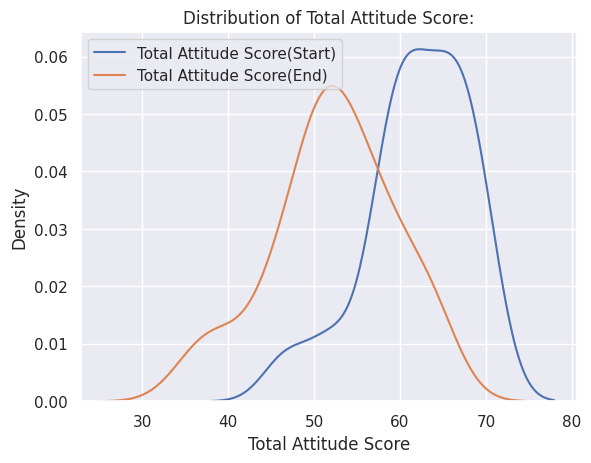

In [105]:
sns.kdeplot(data=subject_information, x="TOTAL SCORE ATTITUDE_START")
sns.kdeplot(data=subject_information, x="TOTAL SCORE ATTITUDE_END")
plt.legend(labels=['Total Attitude Score(Start)', 'Total Attitude Score(End)'])
plt.title("Distribution of Total Attitude Score:")
plt.xlabel("Total Attitude Score")
plt.plot()

[]

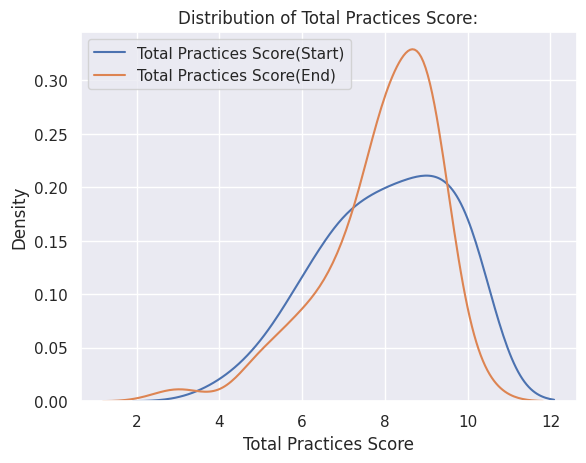

In [106]:
sns.kdeplot(data=subject_information, x="TOTAL SCORE PRACTICES_START")
sns.kdeplot(data=subject_information, x="TOTAL SCORE PRACTICES_END")
plt.legend(labels=['Total Practices Score(Start)', 'Total Practices Score(End)'])
plt.title("Distribution of Total Practices Score:")
plt.xlabel("Total Practices Score")
plt.plot()

In [107]:
hypothesis_test_results = []
metrics = ["KNOWLEDGE TOTAL SCORE", "TOTAL SCORE ATTITUDE", "TOTAL SCORE PRACTICES"]

for metric in metrics:
    two_sided = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values
    )
    greater = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values,
        alternative="greater"
    )
    lesser = stats.ttest_rel(
        subject_information[f"{metric}_START"].values,
        subject_information[f"{metric}_END"].values,
        alternative="less"
    )
    temp_results = pd.DataFrame({
        "Two-Sided": {
            "Test-Statistic": two_sided[0],
            "P-Value": two_sided[1]
        },
        "Greater": {
            "Test-Statistic": greater[0],
            "P-Value": greater[1]
        },
        "Lesser": {
            "Test-Statistic": lesser[0],
            "P-Value": lesser[1]
        }
    }).T.assign(METRIC=metric)

    hypothesis_test_results.append(temp_results)
hypothesis_test_results = pd.concat(hypothesis_test_results, axis=0)
hypothesis_test_results

,Test-Statistic,P-Value,METRIC
Two-Sided,-0.308632,7.586889e-01,KNOWLEDGE TOTAL SCORE
Greater,-0.308632,6.206555e-01,KNOWLEDGE TOTAL SCORE
Lesser,-0.308632,3.793445e-01,KNOWLEDGE TOTAL SCORE
Two-Sided,9.228031,4.771956e-13,TOTAL SCORE ATTITUDE
Greater,9.228031,2.385978e-13,TOTAL SCORE ATTITUDE
Lesser,9.228031,1.000000e+00,TOTAL SCORE ATTITUDE
Two-Sided,0.427832,6.703310e-01,TOTAL SCORE PRACTICES
Greater,0.427832,3.351655e-01,TOTAL SCORE PRACTICES
Lesser,0.427832,6.648345e-01,TOTAL SCORE PRACTICES


In [109]:
subject_information.to_excel("Subject_Level_Info.xlsx")

In [81]:
# subject_information.merge(
#     right=kap_survey_start,
#     left_on = "NAME",
#     right_on = "Name",
#     how="inner"
# ).to_excel("Visualization_data.xlsx")

In [83]:
# attitude = [
#     'Name',
#      'Diabetes is the worst thing that can ever happened to me ',
#      'I would feel embarrassed about having diabetes. ',
#      'Most people would find it difficult to adjust to having diabetes. ',
#      'Seeking help from the clinic for T2DM should be a priority. ',
#      'I think someone with diabetes should follow a controlled diet. ',
#      'I think it is good to include green leafy vegetables and fruits in my daily diet. ',
#      'I think it is good to avoid extra added salts and sugar in my diet. ',
#      'It is good to have fruits rather than sweets. ',
#      'It is important for a diabetic to maintain a healthy weight. ',
#      'Diabetes complications may be prevented if blood glucose level is well control. ',
#      'Checking of your blood sugar level is important. ',
#      'Family members should be screened for diabetes. ',
#      'Missing medicines for a diabetic person has a negative effect on the disease control ',
#      'Regular visits to the clinic or nurses at the clinic enable one to control the disease. ',
# ]
# attitude = kap_survey_start[attitude].copy()
# attitude = attitude[attitude["Name"].isin(subject_information["NAME"])].drop(columns="Name")
# attitude = attitude.replace({1: "Strongly Agree", 2:"Agree", 3:"Neutral", 4: "Disagree", 5: "Strongly Disagree"})
# attitude = pd.melt(
#     attitude,
#     id_vars = None,
#     var_name= "Questions",
#     value_name="Response"
# )
# attitude = pd.crosstab(
#     index = attitude["Questions"],
#     columns = attitude["Response"]
# )
# attitude.to_excel("Attitude Results.xlsx")